In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# custom colors
colors = [
    [0/255.,191/255.,196/255.],
    [248/255.,118/255.,109/255.],
    [150/255.,120/255.,170/255.],
    [200/255.,150/255.,120/255.]
]

def full_df(path: str):
    """Create and return a Pandas DataFrame from all logs in `path`"""
    experiments = [os.path.join(dp, f) for dp, dn, filenames
                   in os.walk(path) for f in filenames
                   if os.path.splitext(f)[1] == '.csv']
    experiments = {str(e): e for e in experiments}
    full_df = pd.DataFrame()
    for exp_name, exp_path in experiments.items():
        if 'aggregate_log' in exp_name:
            continue
        df = pd.read_csv(exp_path)
        df['exp'] = exp_name
        full_df = pd.concat([full_df, df])
    return full_df

def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [12]:
path = '/home/kohring/bnelearn/experiments/pso-final-final'
#path = '/home/kohring/bnelearn/experiments/debug'

single_item_sym_npga = os.path.join(path, 'ESPGLearner', 'single_item/first_price/uniform/symmetric')
single_item_sym_npga_df = full_df(single_item_sym_npga)
single_item_sym_pso = os.path.join(path, 'PSOLearner', 'single_item/first_price/uniform/symmetric')
single_item_sym_pso_df = full_df(single_item_sym_pso)
    
single_item_asym_npga = os.path.join(path, 'ESPGLearner', 'single_item/first_price/uniform/asymmetric')
single_item_asym_npga_df = full_df(single_item_asym_npga)
single_item_asym_pso = os.path.join(path, 'PSOLearner', 'single_item/first_price/uniform/asymmetric')
single_item_asym_pso_df = full_df(single_item_asym_pso)
    
llg_npga = os.path.join(path, 'ESPGLearner', 'LLG')
llg_npga_df = full_df(llg_npga)
llg_pso = os.path.join(path, 'PSOLearner', 'LLG')
llg_pso_df = full_df(llg_pso)

llgfull_npga = os.path.join(path, 'ESPGLearner', 'LLGFull')
llgfull_npga_df = full_df(llgfull_npga)
llgfull_pso = os.path.join(path, 'PSOLearner', 'LLGFull')
llgfull_pso_df = full_df(llgfull_pso)

In [13]:
aggs = {
    'agg0': [percentile(25), 'median', percentile(75)],
    'agg1': ['std', 'mean']
}

In [14]:
def plt_df_function(agg, df, axs_i, label, color, fmt, subrun=None):
    try:
        if subrun:
            df = df[df['subrun'] == subrun]
        df_sub = df[df['tag'] == metric][['epoch', 'value']]
        df_sub = df_sub.groupby('epoch').agg(aggs[agg])
        if agg == 'agg0':
            df_sub.columns = ['lo', 'median', 'hi']
            x, y, lo, hi = df_sub.index, df_sub['median'], df_sub['lo'], df_sub['hi']
            axs[axs_i].fill_between(x, lo, hi, alpha=.1, color=color)
        elif agg == 'agg1':
            df_sub.columns = ['std', 'mean']
            x, y, std = df_sub.index, df_sub['mean'], df_sub['std']
            axs[axs_i].fill_between(x, y-std, y+std, alpha=.3, color=color)
        axs[axs_i].plot(x, y, fmt, label=label, color=color)
        
    except Exception as e:
        # print(e)
        pass

No handles with labels found to put in legend.


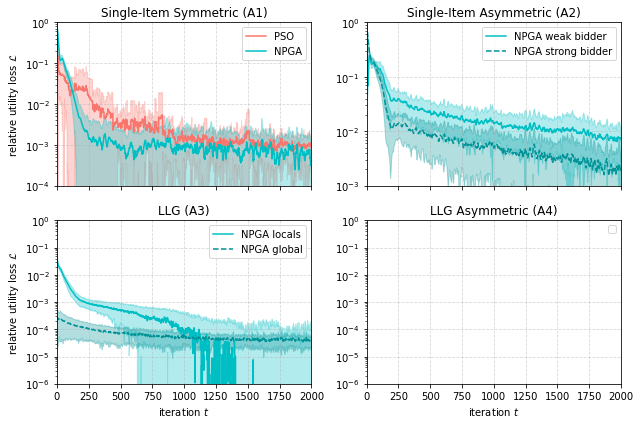

In [15]:
metric = 'eval/epsilon_relative'
x_max = 2000
agg = 'agg1'

color_pso = colors[1]
color_npga = colors[0]
fmt_0 = '-'
fmt_1 = '--'
fmt_2 = '--'

def plt_df(df, axs_i, label, color, fmt, subrun=None):
    return plt_df_function(agg, df, axs_i, label, color, fmt, subrun=subrun)


fig, axs = plt.subplots(2, 2, sharex=True, figsize=(9, 6))
axs = axs.flat

# single-item sym
plt_df(single_item_sym_pso_df, 0, 'PSO', color_pso, fmt_0)
plt_df(single_item_sym_npga_df, 0, 'NPGA', color_npga, fmt_0)

# single item asym 
plt_df(single_item_asym_pso_df, 1, 'PSO weak bidder', color_pso, fmt_0, 'bidder0')
plt_df(single_item_asym_pso_df, 1, 'PSO strong bidder', [c/1.3 for c in color_pso], fmt_1, 'bidder1')
plt_df(single_item_asym_npga_df, 1, 'NPGA weak bidder', color_npga, fmt_0, 'bidder0')
plt_df(single_item_asym_npga_df, 1, 'NPGA strong bidder', [c/1.3 for c in color_npga], fmt_1, 'bidder1')

# LLG 
plt_df(llg_pso_df, 2, 'PSO locals', color_pso, fmt_0, 'locals')
plt_df(llg_pso_df, 2, 'PSO global', [c/1.3 for c in color_pso], fmt_1, 'global')
plt_df(llg_npga_df, 2, 'NPGA locals', color_npga, fmt_0, 'locals')
plt_df(llg_npga_df, 2, 'NPGA global', [c/1.3 for c in color_npga], fmt_1, 'global')

# LLG asymmetric
plt_df(llgfull_pso_df, 3, 'PSO local 1', color_pso, fmt_0, 'local 1')
plt_df(llgfull_pso_df, 3, 'PSO local 2', color_pso, fmt_1, 'local 2')
plt_df(llgfull_pso_df, 3, 'PSO global', [c/1.3 for c in color_pso], fmt_2, 'global')
plt_df(llgfull_npga_df, 3, 'NPGA local 1', color_npga, fmt_0, 'local 1')
plt_df(llgfull_npga_df, 3, 'NPGA local 2', color_npga, fmt_1, 'local 2')
plt_df(llgfull_npga_df, 3, 'NPGA global', [c/1.3 for c in color_npga], fmt_2, 'global')


# joint plot ------------------------------------------------------------------
axs[0].set_title('Single-Item Symmetric (A1)')
axs[1].set_title('Single-Item Asymmetric (A2)')
axs[2].set_title('LLG (A3)')
axs[3].set_title('LLG Asymmetric (A4)')

# plot
for i, ax in enumerate(axs):
    ax.set_yscale('log')
    ax.grid(which='major', alpha=.5, linestyle='--')
    ax.set_xlim([0, x_max])
    if i in [0]:
        ax.set_ylim([1e-4, 1e0])
    if i in [1]:
        ax.set_ylim([1e-3, 1e0])
    if i in [2, 3]:
        ax.set_ylim([1e-6, 1e0])
        ax.set_xlabel('iteration $t$')
    if i in [0, 2]:
        ax.set_ylabel('relative utility loss $\mathcal{L}$')
    ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig('learning_progress.pdf', format='pdf')
plt.show()